In [ ]:
# MACD crossover strategy for the S&P 500 ETF
# Using XGBoost for predicting prices
# Tutorial following: https://www.youtube.com/watch?v=GrJP9FLV3FE&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ&index=5

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import plot_confusion_matrix
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [158]:
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [16]:
SHORT_EMA_PERIOD = 12
LONG_EMA_PERIOD = 26

In [163]:
spy_df = pd.read_csv("SPY.csv")
#spy_df.set_index('Date', inplace=True)
spy_df.columns = spy_df.columns.str.replace(' ', '_')
# spy_df.dropna(axis = 0)

In [27]:
short_ema = spy_df.Close.ewm(span=SHORT_EMA_PERIOD, min_periods=0, adjust=False).mean()
long_ema = spy_df.Close.ewm(span=LONG_EMA_PERIOD, min_periods=0, adjust=False).mean()

In [95]:
spy_df.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2015-04-24,211.660004,211.970001,211.110001,211.649994,188.502869,61327400
2015-04-27,212.330002,212.479996,210.539993,210.770004,187.719086,79358100
2015-04-28,210.740005,211.500000,209.330002,211.440002,188.315811,86863500
2015-04-29,210.369995,211.289993,209.600006,210.570007,187.540955,125684900
2015-04-30,209.880005,210.350006,207.619995,208.460007,185.661713,161304900


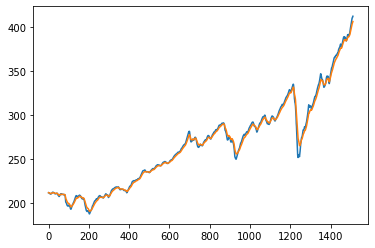

In [36]:
plt.plot(spy_df.index, short_ema)
plt.plot(spy_df.index, long_ema)

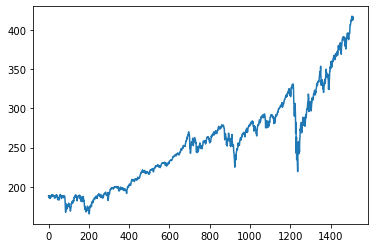

In [38]:
plt.plot(spy_df.Adj_Close)

# EDA

In [32]:
# Evaluating effectiveness of the regressor
# Root mean square error - RMSE
# Mean absolute percentage error - MAPE

In [43]:
spy_df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj_Close    float64
Volume         int64
dtype: object

In [56]:
# Dealing with missing data

In [118]:
for col in spy_df.columns:
    print("nul cols for " + col + ": " + str(len(spy_df.loc[spy_df[col] == ''])))

nul cols for Open: 0
nul cols for High: 0
nul cols for Low: 0
nul cols for Close: 0
nul cols for Adj_Close: 0
nul cols for Volume: 0


# Split data into dependent and independent vars

In [119]:
# X - columns of data used to make classifications
# y - the values that we're trying to predict
X = spy_df.drop('Close', axis=1).copy()
y = spy_df['Close'].copy()

In [120]:
len(X) / 253 # Trading days in a year - data for ~6 years

5.972332015810276

In [122]:
X.head()

,Open,High,Low,Adj_Close,Volume
Date,,,,,
2015-04-24,211.660004,211.970001,211.110001,188.502869,61327400
2015-04-27,212.330002,212.479996,210.539993,187.719086,79358100
2015-04-28,210.740005,211.500000,209.330002,188.315811,86863500
2015-04-29,210.369995,211.289993,209.600006,187.540955,125684900
2015-04-30,209.880005,210.350006,207.619995,185.661713,161304900


In [123]:
y.head()

Date
2015-04-24    211.649994
2015-04-27    210.770004
2015-04-28    211.440002
2015-04-29    210.570007
2015-04-30    208.460007
Name: Close, dtype: float64

In [135]:
# Split into test / training data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)
classifier_objective = 'reg:squarederror'

In [144]:
# Setup a classifier
# xgb_clf = xgb.XGBClassifier(objective=classifier_objective, missing=None, seed=69)
#  xgb_clf.fit(X_train,
#          y_train,
#          verbose=True,
#          early_stopping_rounds=10,
#          eval_metric='aucpr',
#          eval_set=[(X_test, y_test)])

In [131]:
# plot_confusion_matrix(xgbr, X_test, y_test, values_format='d')

## Optimization

In [159]:
# Round 1
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective=classifier_objective,
    seed=69,
    subsample=0.9,
    colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0, # 2 for output,
    n_jobs=10,
    cv=3
)

# optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)
# print(optimal_params.best_params_)

In [168]:
# OHLC (open/high/low/close)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Ohlc(x=spy_df.Date,
                      open=spy_df.Open,
                      high=spy_df.High,
                      low=spy_df.Low,
                      close=spy_df.Close,
                      name='Price'), row=1, col=1)


In [173]:
# Add features
# Calculate moving avergaes to use as features
spy_df['EMA_9'] = spy_df['Close'].ewm(9).mean().shift()
spy_df['EMA_5'] = spy_df['Close'].rolling(5).mean().shift()
spy_df['EMA_10'] = spy_df['Close'].rolling(10).mean().shift()
spy_df['EMA_15'] = spy_df['Close'].rolling(15).mean().shift()
spy_df['EMA_30'] = spy_df['Close'].rolling(30).mean().shift()